In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tnrange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import copy
from IPython import display
import time
import sys
import japanize_matplotlib

import requests
import json

import MeCab
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

import sys
sys.path.append("../input")
from API_key import apikey

from scipy import stats
import warnings
warnings.simplefilter('ignore')
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from scipy.stats import mannwhitneyu

/home/ku-miyazaki/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import seaborn as sns
import scienceplots
plt.style.use(['science','nature'])
from matplotlib import rc
rc("text", usetex=False)

In [3]:
with open('toxic_scores_comment_en_all.pickle', mode='rb') as f:
    tmp_dict = pickle.load(f)
    
tmp_tmp_dict = {}
for i in tmp_dict:
    tmp_tmp_dict[i] = tmp_dict[i]['attributeScores']['TOXICITY']['summaryScore']["value"]


with open('deep_senti_comment.pickle', mode='rb') as f:
    tmp_dict_id_senti = pickle.load(f)

df_id_senti = pd.DataFrame(tmp_dict_id_senti).T

with open('df_comments_all.pickle', mode='rb') as f:
    df_comments_all = pickle.load(f)
    
df_comments_all["author_id"] = df_comments_all["authorChannelUrl"].apply(lambda x: x.strip("http://www.youtube.com/channel/"))
df_comments_all["toxicity"] = df_comments_all["id"].map(tmp_tmp_dict)
df_comments_all = df_comments_all.merge(df_id_senti, left_on="id", right_index=True)
df_comments_all = df_comments_all[df_comments_all["fear"].map(type) == float]
df_comments_all["fear"] = df_comments_all["fear"].astype(float)
df_comments_all = df_comments_all[df_comments_all["toxicity"].notnull()]
df_comments_all["commentCountsByVideo"] = df_comments_all["videoId"].map(df_comments_all["videoId"].value_counts().to_dict())
df_comments_all = df_comments_all[df_comments_all["commentCountsByVideo"] >= 10]

feature building

In [4]:
df_regression = pd.concat([
    df_comments_all.groupby("videoId")["toxicity"].mean(),
    df_comments_all.groupby("videoId")["toxicity"].max(),
    df_comments_all.groupby("videoId")["fear"].mean(),
    df_comments_all.groupby("videoId")["fear"].max(),
    np.log(df_comments_all["videoId"].value_counts())
], axis=1)
df_regression.columns = ["comment_toxicity_mean", "comment_toxicity_max", "comment_fear_mean", "comment_fear_max", "commentCounts"]

In [5]:
json_file_path = "../input/groundtruth_dataset.json"
df_videos = pd.DataFrame([json.loads(line)
        for line in open(json_file_path, 'r', encoding='utf-8')])

In [6]:
df_videos = pd.concat([
    df_videos,
    df_videos["annotation"].apply(lambda x: pd.Series(x)),
    df_videos["statistics"].apply(lambda x: pd.Series(x)),
    df_videos["snippet"].apply(lambda x: pd.Series(x)),
], axis=1)
df_videos = df_videos[df_videos["id"].isin(df_regression.index)]

In [7]:
dict_videoid_label = df_videos.set_index("id")['label'].map(
    {
        'pseudoscience': 1,
        "science": 0,
        'irrelevant': 0
    }
).to_dict()
df_regression["pseudoscience"] = df_regression.index.map(dict_videoid_label)

In [8]:
# view count （numerical value（logged））
dict_videoid_viewCount = df_videos.set_index("id")["viewCount"].astype(int).map(np.log).to_dict()
df_regression["viewCount"] = df_regression.index.map(dict_videoid_viewCount)

# like/dislike（numerical value）
dict_videoid_likeRatio = (df_videos.set_index("id")["likeCount"].fillna(0).astype(int) / \
(df_videos.set_index("id")["likeCount"].fillna(0).astype(int) + \
df_videos.set_index("id")["dislikeCount"].fillna(0).astype(int))).to_dict()
df_regression["dict_videoid_likeRatio"] = df_regression.index.map(dict_videoid_likeRatio)

# date
df_videos["publishedAt"] = df_videos["publishedAt"].map(pd.Timestamp)
df_videos["published_day"] = (df_videos["publishedAt"] - min(df_videos["publishedAt"])).apply(lambda x: x.days)
dict_videoid_publishday = df_videos.set_index("id")["published_day"].to_dict()
df_regression["dict_videoid_publishday"] = df_regression.index.map(dict_videoid_publishday)

# title
with open('deep_senti_title.pickle', mode='rb') as f:
    dict_title_sentiment = pickle.load(f)
df_regression["title_fear"] = df_regression.apply(lambda x: dict_title_sentiment[x.name]["fear"] if dict_title_sentiment[x.name] != "error" else None, axis=1)

with open('toxic_scores_title_en.pickle', mode='rb') as f:
    dict_title_toxicity = pickle.load(f)
df_regression["title_toxicity"] = df_regression.apply(lambda x: dict_title_toxicity[x.name]['attributeScores']['INSULT']['summaryScore']["value"] if x.name in  dict_title_toxicity else None, axis=1)

# description
with open('deep_senti_description.pickle', mode='rb') as f:
    dict_description_sentiment = pickle.load(f)
df_regression["description_fear"] = df_regression.apply(lambda x: dict_description_sentiment[x.name]["fear"] if dict_description_sentiment[x.name] != "error" else None, axis=1)


with open('toxic_scores_description_en.pickle', mode='rb') as f:
    dict_description_toxicity = pickle.load(f)
df_regression["description_toxicity"] = df_regression.apply(lambda x: dict_description_toxicity[x.name]['attributeScores']['INSULT']['summaryScore']["value"] if x.name in  dict_description_toxicity else None, axis=1)


# subscriber count
with open('tmp_dict_chennelid_info.pickle', mode='rb') as f:
    tmp_dict_chennelid_info = pickle.load(f)
    
videoId_channelId = df_videos.set_index("id")["channelId"].to_dict()

tmp_subscriber_count = []
for videoId in df_regression.index:
    channel_id =  videoId_channelId[videoId]
    if channel_id  in tmp_dict_chennelid_info:
        resource = tmp_dict_chennelid_info[channel_id ]
        if "items" in resource:
            tmp_subscriber_count.append(resource['items'][0]['statistics']['subscriberCount'])
        else:
            tmp_subscriber_count.append(None)
    else:
        tmp_subscriber_count.append(None)

df_regression["subscriber_count"] = tmp_subscriber_count
df_regression = df_regression[df_regression["subscriber_count"].notnull()]
df_regression["subscriber_count"] = df_regression["subscriber_count"].astype(int)


# video fear
with open('deep_senti_caption.pickle', mode='rb') as f:
    dict_caption_sentiment = pickle.load(f)

df_regression["caption_fear"] = df_regression.apply(lambda x: dict_caption_sentiment[x.name]["fear"] if dict_caption_sentiment[x.name] != "error" else None, axis=1)


# video toxicity
with open('toxic_scores_captions.pickle', mode='rb') as f:
    dict_caption_toxicity = pickle.load(f)

df_regression["caption_toxicity"] = df_regression.apply(lambda x: dict_caption_toxicity[x.name]['attributeScores']['INSULT']['summaryScore']["value"] if x.name in  dict_caption_toxicity else None, axis=1)


# video topic
with open('df_transcripts_topic.pickle', mode='rb') as f:
    df_transcripts = pickle.load(f)

df_transcripts = df_transcripts.set_index("id")

df_topics_caption = pd.get_dummies(df_transcripts["topic"]).loc[:, [0, 1,3,4,5]]

df_topics_caption.columns = ["topic_0", "topic_1",  "topic_3", "topic_4", "topic_5"]

df_regression = pd.concat([
    df_regression,
    df_topics_caption
], axis=1)

df_regression = df_regression[df_regression["comment_toxicity_mean"].notnull()]

df_regression = df_regression[df_regression['dict_videoid_likeRatio'].notnull()]

df_regression = df_regression[df_regression['title_toxicity'].notnull()]
df_regression = df_regression[df_regression['description_toxicity'].notnull()]

In [9]:
high_toxicity_thre = df_comments_all["toxicity"].quantile(0.9)
high_fear_thre = df_comments_all["fear"].quantile(0.9)

In [10]:
tmp_argmax = np.argmax(df_comments_all.loc[:, ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]].values, axis=1)

In [11]:
df_comments_all["comment_order_byVideo"] = 1
df_comments_all = df_comments_all.sort_values("publishedAt")
df_comments_all["comment_order_byVideo"] = df_comments_all.groupby(['videoId'])['comment_order_byVideo'].cumsum()


In [12]:

like_thre = 0.5
dict_df_regression = {}
for range_ in [10,20,30,40,50]:
    print("===="*30)
    print(range_)
    dict_toxicity_former = {}
    dict_toxicity_former_mean = {}
    dict_toxicity_former_max = {}
    dict_toxicity_latter = {}
    dict_toxicity_latter_mean = {}
    dict_fear_former = {}
    dict_fear_former_mean = {}
    dict_fear_former_max = {}
    dict_fear_latter = {}
    dict_fear_latter_mean = {}
    dict_toxicity_like_former = {}
    dict_fear_like_former = {}
    dict_like_former = {}
    dict_highlike_toxicity_former = {}
    dict_highlike_fear_former = {}
    dict_highlike_toxicity_former_mean = {}
    dict_highlike_fear_former_mean = {}
    dict_lowlike_toxicity_former = {}
    dict_lowlike_fear_former = {}
    


    # tmp_list_match = []
    for c, ind_ in tqdm(enumerate(df_comments_all["videoId"].value_counts().index)):
        tmp_df = df_comments_all[df_comments_all["videoId"] == ind_]
        tmp_df = tmp_df.sort_values("publishedAt").reset_index()
    #     break
    #     range_ = int(len(tmp_df)*0.1)
    
    

        if len(tmp_df) < 100:
            continue
#         if len(tmp_df) < (range_*2+1):
#             continue

    

        dict_toxicity_former[ind_] = (tmp_df.iloc[:range_]["toxicity"] > high_toxicity_thre).sum() / len(tmp_df.iloc[:range_])# tmp_df.iloc[:range_]["toxicity"].mean()
        dict_toxicity_latter[ind_] = (tmp_df.iloc[range_:]["toxicity"] > high_toxicity_thre).sum() / len(tmp_df.iloc[:range_])
        dict_fear_latter[ind_] = (tmp_df.iloc[range_:]["fear"]>high_fear_thre ).sum() / len(tmp_df.iloc[range_:])
        dict_fear_former[ind_] = (tmp_df.iloc[:range_]["fear"]>high_fear_thre ).sum() / len(tmp_df.iloc[:range_])
        dict_highlike_toxicity_former[ind_] = (tmp_df.iloc[:range_][tmp_df.iloc[:range_]["likeCount"] > tmp_df.iloc[:range_]["likeCount"].quantile(like_thre)]["toxicity"] > high_toxicity_thre).sum() / len(tmp_df.iloc[:range_])
        dict_highlike_fear_former[ind_] = (tmp_df.iloc[:range_][tmp_df.iloc[:range_]["likeCount"] > tmp_df.iloc[:range_]["likeCount"].quantile(like_thre)]["fear"]>high_fear_thre).sum() / len(tmp_df.iloc[:range_])
        dict_lowlike_toxicity_former[ind_] = (tmp_df.iloc[:range_][tmp_df.iloc[:range_]["likeCount"] <= tmp_df.iloc[:range_]["likeCount"].quantile(like_thre)]["toxicity"] > high_toxicity_thre).sum() / len(tmp_df.iloc[:range_])
        dict_lowlike_fear_former[ind_] = (tmp_df.iloc[:range_][tmp_df.iloc[:range_]["likeCount"] <= tmp_df.iloc[:range_]["likeCount"].quantile(like_thre)]["fear"]>high_fear_thre).sum()/ len(tmp_df.iloc[:range_])

        
        dict_toxicity_former_mean[ind_] = tmp_df.iloc[:range_]["toxicity"].mean()# tmp_df.iloc[:range_]["toxicity"].mean()
        dict_toxicity_latter_mean[ind_] = tmp_df.iloc[range_:]["toxicity"].mean()
        dict_fear_latter_mean[ind_] = tmp_df.iloc[range_:]["fear"].mean()
        dict_fear_former_mean[ind_] = tmp_df.iloc[:range_]["fear"].mean()
        dict_highlike_toxicity_former_mean[ind_] = tmp_df.iloc[:range_][tmp_df.iloc[:range_]["likeCount"] > tmp_df.iloc[:range_]["likeCount"].quantile(like_thre)]["toxicity"].mean()
        dict_highlike_fear_former_mean[ind_] = tmp_df.iloc[:range_][tmp_df.iloc[:range_]["likeCount"] > tmp_df.iloc[:range_]["likeCount"].quantile(like_thre)]["fear"].mean()
        
    df_regression["toxicity_former"] = df_regression.index.map(dict_toxicity_former)
    df_regression["toxicity_former_max"] = df_regression.index.map(dict_toxicity_former_max)
    df_regression["toxicity_latter"] = df_regression.index.map(dict_toxicity_latter)
    df_regression["toxicity_like_former"] = df_regression.index.map(dict_toxicity_like_former)
    df_regression["fear_like_former"] = df_regression.index.map(dict_fear_like_former)
    df_regression["like_former"] = df_regression.index.map(dict_like_former)
    df_regression["fear_latter"] = df_regression.index.map(dict_fear_latter)
    df_regression["fear_former"] = df_regression.index.map(dict_fear_former)
    df_regression["fear_former_max"] = df_regression.index.map(dict_fear_former_max)
    df_regression["highlike_toxicity_former"] = df_regression.index.map(dict_highlike_toxicity_former)
    df_regression["highlike_fear_former"] = df_regression.index.map(dict_highlike_fear_former)
    df_regression["lowlike_toxicity_former"] = df_regression.index.map(dict_lowlike_toxicity_former)
    df_regression["lowlike_fear_former"] = df_regression.index.map(dict_lowlike_fear_former)
                                           
                                           
    df_regression["toxicity_former_mean"] = df_regression.index.map(dict_toxicity_former_mean)
    df_regression["toxicity_latter_mean"] = df_regression.index.map(dict_toxicity_latter_mean)
    df_regression["fear_latter_mean"] = df_regression.index.map(dict_fear_latter_mean)
    df_regression["fear_former_mean"] = df_regression.index.map(dict_fear_former_mean)
    df_regression["highlike_toxicity_former_mean"] = df_regression.index.map(dict_highlike_toxicity_former_mean)
    df_regression["highlike_fear_former_mean"] = df_regression.index.map(dict_highlike_fear_former_mean)
    
    
    df_regression = df_regression[df_regression["toxicity_former"].notnull()]
    print(len(df_regression))
    df_regression = df_regression[df_regression["caption_toxicity"].notnull()]
    print(len(df_regression))
    df_regression = df_regression[df_regression["caption_fear"].notnull()]
    print(len(df_regression))
    df_regression = df_regression[df_regression["highlike_toxicity_former"].notnull()]
    print(len(df_regression))
    
    dict_df_regression[range_] = df_regression.copy()
    

10


0it [00:00, ?it/s]

751
547
484
484
20


0it [00:00, ?it/s]

484
484
484
484
30


0it [00:00, ?it/s]

484
484
484
484
40


0it [00:00, ?it/s]

484
484
484
484
50


0it [00:00, ?it/s]

484
484
484
484


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [14]:
df_regression.shape

(484, 40)

In [15]:
# 高toxicityがあるかどうか
# range_ = 20
regression_result_3 = {}
for range_ in [10,20,30,40,50]:

    df_regression = dict_df_regression[range_].copy()
    scaler = MinMaxScaler()
    df_regression = pd.DataFrame(scaler.fit_transform(df_regression), index=df_regression.index, columns=df_regression.columns)
    print(len(df_regression))

    df_regression_4 = df_regression.loc[:, [
    #     'comment_fear_mean',
        'pseudoscience', 
        'viewCount',
        'dict_videoid_likeRatio', 
        "subscriber_count",
        "title_fear",
        "title_toxicity",
        "description_fear",
        "description_toxicity",
        'caption_fear', 
        'caption_toxicity',
        'topic_0',
        'topic_1',
    #     'topic_2', 
        'topic_3',
        'topic_4',
        'topic_5',
    #     'comment_toxicity_mean', 
        'commentCounts',
    #     "toxicity_former",
    #     "toxicity_former_max",
    #     "toxicity_latter",
#         "toxicity_like_former",
#         "fear_like_former",
    #     "like_former",
        "fear_latter_mean",
        "fear_former_mean",
    #     "fear_former_max",
        "highlike_toxicity_former_mean",
#         "highlike_fear_former",
#         "lowlike_toxicity_former",
#         "lowlike_fear_former",
    ]]

#     break
    df_regression_4 = df_regression_4[df_regression_4.isnull().sum(axis=1) == 0]
    
#     df_regression_4_x = df_regression_4.loc[:, [i for i in df_regression_4.columns if i != "fear_latter"] ]
#     df_regression_4_y = df_regression_4["fear_latter"] 
    df_regression_4_x = df_regression_4.loc[:, [i for i in df_regression_4.columns if i != "fear_latter_mean"] ]
    df_regression_4_y = df_regression_4["fear_latter_mean"] 

    #vifを計算する
    vif = pd.DataFrame()
    X = add_constant(df_regression_4_x)

    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    #vifを計算結果を出力する
    print(vif)

    y = df_regression_4_y
    X = add_constant(df_regression_4_x)

    lr = sm.OLS(y, X)
    lr_result = lr.fit()
    print(lr_result.params)
    print(lr_result.summary())

    y_pred = lr.predict(lr_result.params)
    
    regression_result_3[range_] = copy.copy(lr_result)
    

484
    VIF Factor                       features
0   124.240766                          const
1     1.045672                  pseudoscience
2     1.924784                      viewCount
3     1.202929         dict_videoid_likeRatio
4     1.276882               subscriber_count
5     1.170319                     title_fear
6     1.160094                 title_toxicity
7     1.141001               description_fear
8     1.152149           description_toxicity
9     1.130780                   caption_fear
10    1.274162               caption_toxicity
11    1.259265                        topic_0
12    1.842866                        topic_1
13    2.101289                        topic_3
14    1.939436                        topic_4
15    1.562090                        topic_5
16    1.707174                  commentCounts
17    1.099645               fear_former_mean
18    1.064218  highlike_toxicity_former_mean
const                            0.079295
pseudoscience                   -0

In [16]:
# 高toxicityがあるかどうか
regression_result_4 = {}
for range_ in [10,20,30,40,50]:
    
    df_regression = dict_df_regression[range_].copy()
    scaler = MinMaxScaler()
    df_regression = pd.DataFrame(scaler.fit_transform(df_regression), index=df_regression.index, columns=df_regression.columns)
    print(len(df_regression))

    df_regression_4 = df_regression.loc[:, [
    #     'comment_fear_mean',
        'pseudoscience', 
        'viewCount',
        'dict_videoid_likeRatio', 
        "subscriber_count",
        "title_fear",
        "title_toxicity",
        "description_fear",
        "description_toxicity",
        'caption_fear', 
        'caption_toxicity',
        'topic_0',
        'topic_1',
    #     'topic_2', 
        'topic_3',
        'topic_4',
        'topic_5',
    #     'comment_toxicity_mean', 
        'commentCounts',
        "toxicity_former_mean",
    #     "toxicity_former_max",
    #     "toxicity_latter",
#         "toxicity_like_former",
#         "fear_like_former",
    #     "like_former",
        "fear_latter_mean",
        "fear_former_mean",
    #     "fear_former_max",
#         "highlike_toxicity_former",
#         "highlike_fear_former",
#         "lowlike_toxicity_former",
#         "lowlike_fear_former",
    ]]
    df_regression_4 = df_regression_4[df_regression_4.isnull().sum(axis=1) == 0]

#     df_regression_4_x = df_regression_4.loc[:, [i for i in df_regression_4.columns if i != "fear_latter"] ]
#     df_regression_4_y = df_regression_4["fear_latter"] 
    df_regression_4_x = df_regression_4.loc[:, [i for i in df_regression_4.columns if i != "fear_latter_mean"] ]
    df_regression_4_y = df_regression_4["fear_latter_mean"] 

    #vifを計算する
    vif = pd.DataFrame()
    X = add_constant(df_regression_4_x)

    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    #vifを計算結果を出力する
    print(vif)

    y = df_regression_4_y
    X = add_constant(df_regression_4_x)

    lr = sm.OLS(y, X)
    lr_result = lr.fit()
    print(lr_result.params)
    print(lr_result.summary())

    y_pred = lr.predict(lr_result.params)
    
    regression_result_4[range_] = copy.copy(lr_result)
    

484
    VIF Factor                features
0   126.760278                   const
1     1.047692           pseudoscience
2     1.955954               viewCount
3     1.198790  dict_videoid_likeRatio
4     1.266997        subscriber_count
5     1.172304              title_fear
6     1.167364          title_toxicity
7     1.133423        description_fear
8     1.159332    description_toxicity
9     1.124770            caption_fear
10    1.278426        caption_toxicity
11    1.261925                 topic_0
12    1.838384                 topic_1
13    2.096598                 topic_3
14    1.948457                 topic_4
15    1.558967                 topic_5
16    1.736818           commentCounts
17    1.086698    toxicity_former_mean
18    1.102611        fear_former_mean
const                     0.082434
pseudoscience            -0.001272
viewCount                -0.079745
dict_videoid_likeRatio    0.062825
subscriber_count          0.007634
title_fear                0.115550
title_

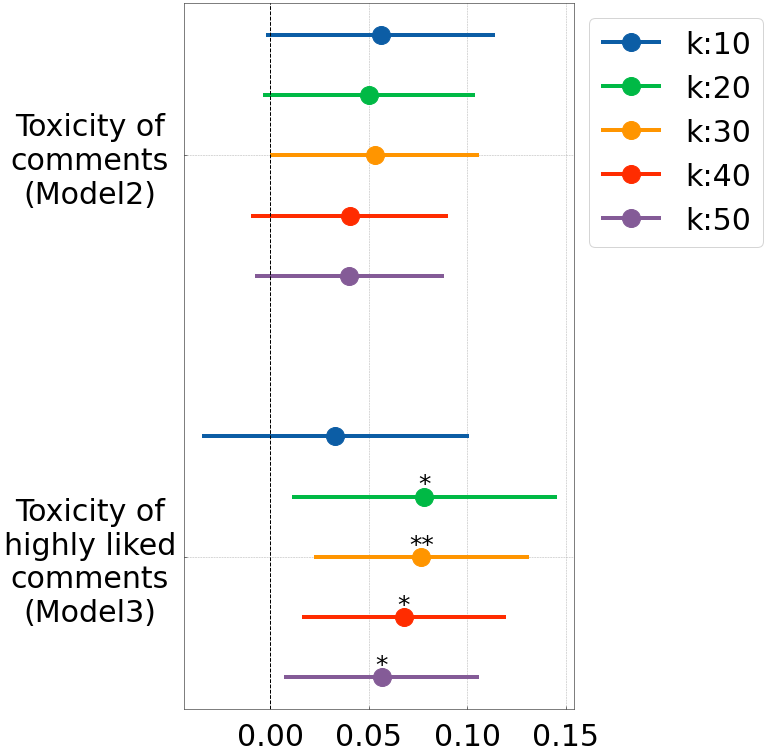

In [17]:
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(7, 13))
list_plot = []
list_range = [10,20,30,40,50]
for range_ in list_range:
    lr_result = regression_result_3[range_]
    
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(lr_result.summary().tables[1].data)
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']

    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    coef_df = coef_df.loc[[
        "highlike_toxicity_former_mean",
#         "highlike_toxicity_former",
#         "highlike_fear_former",
#         "fear_former",
#         "lowlike_toxicity_former",
#         "lowlike_fear_former",
    ], :]
    
    list_plot.append(coef_df)


    # x-labels
    variables = list(coef_df.index.values)

    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    coef_df['range'] = range_

    
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# sns.set_context("poster")

# colors = ['red', 'green', 'blue', 'cyan', 'magenta', "black", "pink", "orange"]

for ii, coef_df in enumerate(list_plot):
    i = 0
    for c, row in coef_df.iterrows():
        if i == 0:
            label = "k:" + str(list_range[ii])
        else:
            label = None
        ax.errorbar(
            row['coef'],
            i+0.3-(0.15*ii),
            yerr=0,
            xerr=row['errors'],
            label=label,
#             color=colors[ii],
#             ecolor=colors[ii],
            marker='o',
            ls='',
            ms=18,
            linewidth=4,
        )
        
        if row["P>|t|"] < 0.001:
            signi = "***"
        elif row["P>|t|"] < 0.01:
            signi = "**"
        elif row["P>|t|"] < 0.05:
            signi = "*"
#         elif row["P>|t|"] < 0.1:
#             signi = "*"
        else:
            signi = ""
        
        ax.text(
            row['coef'], 
            i+0.3-(0.15*ii), 
            signi, 
            ha='center', 
            va='bottom', 
            color="black",
            fontdict={"size":25}
        )
        
        
        i += 1

        
        
        
list_plot = []
# list_range = [10,20,30,40,50]
for range_ in list_range:
    lr_result = regression_result_4[range_]
    
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(lr_result.summary().tables[1].data)
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']

    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    coef_df = coef_df.loc[[
        "toxicity_former_mean", 
        #         "toxicity_former", 
#         "fear_former"
    ], :]
    
    list_plot.append(coef_df)


    # x-labels
    variables = list(coef_df.index.values)

    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    coef_df['range'] = range_

    
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# sns.set_context("poster")

# colors = ['red', 'green', 'blue', 'cyan', 'magenta', "black", "pink", "orange"]

for ii, coef_df in enumerate(list_plot):
    i = 1
    for c, row in coef_df.iterrows():
        if i == 0:
            label = "Window:" + str(list_range[ii])
        else:
            label = None
        ax.errorbar(
            row['coef'],
            i+0.3-(0.15*ii),
            yerr=0,
            xerr=row['errors'],
            label=label,
            color=list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[ii % len(list(plt.rcParams['axes.prop_cycle'].by_key()['color']))],
            ecolor=list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[ii % len(list(plt.rcParams['axes.prop_cycle'].by_key()['color']))],
            marker='o',
            ms=18,
            linewidth=4,
            ls=''
        )
        
        if row["P>|t|"] < 0.001:
            signi = "***"
        elif row["P>|t|"] < 0.01:
            signi = "**"
        elif row["P>|t|"] < 0.05:
            signi = "*"
#         elif row["P>|t|"] < 0.1:
#             signi = "*"
        else:
            signi = ""
        
        ax.text(
            row['coef'], 
            i+0.3-(0.15*ii),
            signi, 
            ha='center', 
            va='bottom', 
            color="black",
            fontdict={"size":25}
        )
        
        
        i += 1        



# # # Set title & labels
# plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
# ax.set_ylabel('Coefficients',fontsize=22)
# ax.set_xlabel('',fontsize=22)
ax.set_yticks([0, 1]) 
ax.set_yticklabels(
#     labels=["Highly-liked\ntoxic\ncomments\n(Model5)","Toxic\ncomments\n(Model4)"],
    labels=["Toxicity of\nhighly liked\ncomments\n(Model3)","Toxicity of\ncomments\n(Model2)"],
    ha="center",
    fontsize=22)

# Line to define zero on the y-axis
ax.grid( linestyle='--')
ax.axvline(x=0, linestyle='--', color='black', linewidth=1)
# get handles
handles, labels = ax.get_legend_handles_labels()
for i in range(len(list_range)):
    handles[i] = (handles[i].lines[0], handles[i].lines[1], tuple([handles[i].lines[2][0]]))
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1), prop=dict(size=30), frameon=True)
# ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 0.75), prop=dict(size=30), frameon=True)

ax.minorticks_off()
ax.xaxis.set_ticks_position('bottom') 
ax.yaxis.set_ticks_position('left') 


ax.tick_params(axis='x', which='major', labelsize=30, pad=13)
ax.tick_params(axis='y', which='major', labelsize=30, pad=94)
# ax.set_title("Highly-liked toxic comments", size=36, pad=15)

# ax.set_xscale("log")
# plt.savefig("figures/coef_toxic_both.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# 高toxicityがあるかどうか
# range_ = 20
regression_result_3 = {}
for range_ in [10,20,30,40,50]: 

    df_regression = dict_df_regression[range_].copy()
    print(len(df_regression))

    df_regression_4 = df_regression.loc[:, [
    #     'comment_fear_mean',
        'pseudoscience', 
        'viewCount',
        'dict_videoid_likeRatio', 
        "subscriber_count",
        "title_fear",
        "title_toxicity",
        "description_fear",
        "description_toxicity",
        'caption_fear', 
        'caption_toxicity',
        'topic_0',
        'topic_1',
    #     'topic_2', 
        'topic_3',
        'topic_4',
        'topic_5',
    #     'comment_toxicity_mean', 
        'commentCounts',
        "toxicity_former_mean",
    #     "toxicity_former_max",
        "toxicity_latter_mean",
#         "toxicity_like_former",
#         "fear_like_former",
    #     "like_former",
#         "fear_latter",
#         "fear_former",
    #     "fear_former_max",
#         "highlike_toxicity_former",
        "highlike_fear_former_mean",
#         "lowlike_toxicity_former",
#         "lowlike_fear_former",
    ]]
    df_regression_4 = df_regression_4[df_regression_4.isnull().sum(axis=1) == 0]

    df_regression_4_x = df_regression_4.loc[:, [i for i in df_regression_4.columns if i != "toxicity_latter_mean"] ]
    df_regression_4_y = df_regression_4["toxicity_latter_mean"] 

    #vifを計算する
    vif = pd.DataFrame()
    X = add_constant(df_regression_4_x)

    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    #vifを計算結果を出力する
    print(vif)

    y = df_regression_4_y
    X = add_constant(df_regression_4_x)

    lr = sm.OLS(y, X)
    lr_result = lr.fit()
    print(lr_result.params)
    print(lr_result.summary())

    y_pred = lr.predict(lr_result.params)
    
    regression_result_3[range_] = copy.copy(lr_result)
    

484
    VIF Factor                   features
0   299.130123                      const
1     1.039255              pseudoscience
2     1.939109                  viewCount
3     1.206415     dict_videoid_likeRatio
4     1.282335           subscriber_count
5     1.165251                 title_fear
6     1.159791             title_toxicity
7     1.135622           description_fear
8     1.152261       description_toxicity
9     1.126951               caption_fear
10    1.276158           caption_toxicity
11    1.256402                    topic_0
12    1.843065                    topic_1
13    2.099184                    topic_3
14    1.948047                    topic_4
15    1.556732                    topic_5
16    1.712747              commentCounts
17    1.067016       toxicity_former_mean
18    1.089862  highlike_fear_former_mean
const                        1.832361e-01
pseudoscience                1.238041e-03
viewCount                   -7.406458e-03
dict_videoid_likeRatio      -1

In [19]:
# toxicity
regression_result_4 = {}
for range_ in [10,20,30,40,50]:
    
    df_regression = dict_df_regression[range_].copy()
    print(len(df_regression))

    df_regression_4 = df_regression.loc[:, [
    #     'comment_fear_mean',
        'pseudoscience', 
        'viewCount',
        'dict_videoid_likeRatio', 
        "subscriber_count",
        "title_fear",
        "title_toxicity",
        "description_fear",
        "description_toxicity",
        'caption_fear', 
        'caption_toxicity',
        'topic_0',
        'topic_1',
    #     'topic_2', 
        'topic_3',
        'topic_4',
        'topic_5',
    #     'comment_toxicity_mean', 
        'commentCounts',
        "toxicity_former_mean",
    #     "toxicity_former_max",
        "toxicity_latter_mean",
#         "toxicity_like_former",
#         "fear_like_former",
    #     "like_former",
#         "fear_latter",
        "fear_former_mean",
    #     "fear_former_max",
#         "highlike_toxicity_former",
#         "highlike_fear_former",
#         "lowlike_toxicity_former",
#         "lowlike_fear_former",
    ]]
    df_regression_4 = df_regression_4[df_regression_4.isnull().sum(axis=1) == 0]

    df_regression_4_x = df_regression_4.loc[:, [i for i in df_regression_4.columns if i != "toxicity_latter_mean"] ]
    df_regression_4_y = df_regression_4["toxicity_latter_mean"] 

    #vifを計算する
    vif = pd.DataFrame()
    X = add_constant(df_regression_4_x)

    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    #vifを計算結果を出力する
    print(vif)

    y = df_regression_4_y
    X = add_constant(df_regression_4_x)

    lr = sm.OLS(y, X)
    lr_result = lr.fit()
    print(lr_result.params)
    print(lr_result.summary())

    y_pred = lr.predict(lr_result.params)
    
    regression_result_4[range_] = copy.copy(lr_result)
    

484
    VIF Factor                features
0   299.848202                   const
1     1.047692           pseudoscience
2     1.955954               viewCount
3     1.198790  dict_videoid_likeRatio
4     1.266997        subscriber_count
5     1.172304              title_fear
6     1.167364          title_toxicity
7     1.133423        description_fear
8     1.159332    description_toxicity
9     1.124770            caption_fear
10    1.278426        caption_toxicity
11    1.261925                 topic_0
12    1.838384                 topic_1
13    2.096598                 topic_3
14    1.948457                 topic_4
15    1.558967                 topic_5
16    1.736818           commentCounts
17    1.086698    toxicity_former_mean
18    1.102611        fear_former_mean
const                     1.842366e-01
pseudoscience             7.041652e-04
viewCount                -7.638668e-03
dict_videoid_likeRatio   -1.250943e-02
subscriber_count         -1.069339e-09
title_fear           

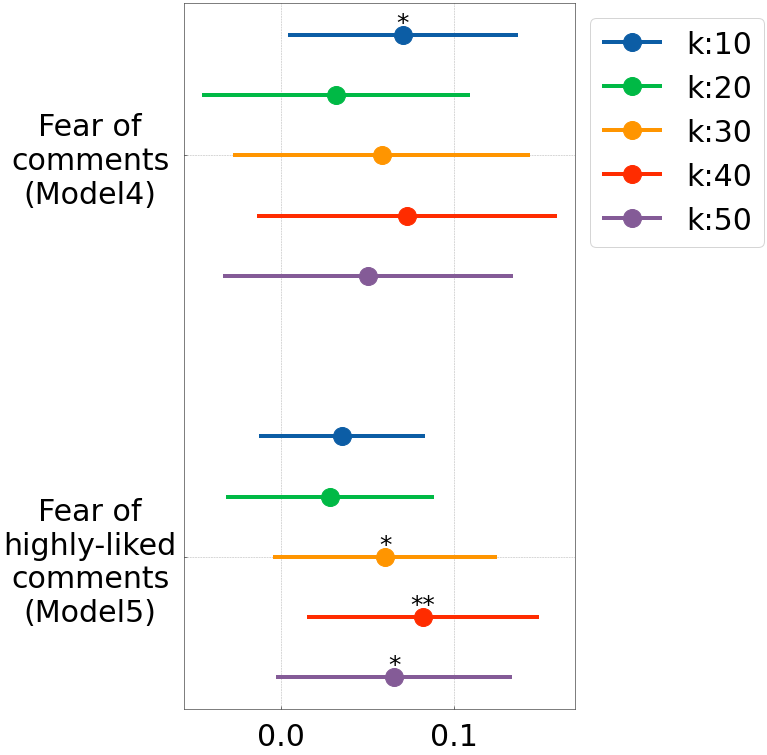

In [20]:
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(7, 13))
list_plot = []
list_range = [10,20,30,40,50]
for range_ in list_range:
    lr_result = regression_result_3[range_]
    
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(lr_result.summary().tables[1].data)
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']

    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    coef_df = coef_df.loc[[
#         "highlike_toxicity_former",
        "highlike_fear_former_mean",
#         "fear_former",
#         "lowlike_toxicity_former",
#         "lowlike_fear_former",
    ], :]
    
    list_plot.append(coef_df)


    # x-labels
    variables = list(coef_df.index.values)

    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    coef_df['range'] = range_

    
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# sns.set_context("poster")

# colors = ['red', 'green', 'blue', 'cyan', 'magenta', "black", "pink", "orange"]

for ii, coef_df in enumerate(list_plot):
    i = 0
    for c, row in coef_df.iterrows():
        if i == 0:
            label = "k:" + str(list_range[ii])
        else:
            label = None
        ax.errorbar(
            row['coef'],
            i+0.3-(0.15*ii),
            yerr=0,
            xerr=row['errors'],
            label=label,
#             color=colors[ii],
#             ecolor=colors[ii],
            marker='o',
            ls='',
            ms=18,
            linewidth=4,
        )
        
        if row["P>|t|"] < 0.001:
            signi = "****"
        elif row["P>|t|"] < 0.01:
            signi = "***"
        elif row["P>|t|"] < 0.05:
            signi = "**"
        elif row["P>|t|"] < 0.1:
            signi = "*"
        else:
            signi = ""
        
        ax.text(
            row['coef'], 
            i+0.3-(0.15*ii), 
            signi, 
            ha='center', 
            va='bottom', 
            color="black",
            fontdict={"size":25}
        )
        
        
        i += 1

        
        
        
list_plot = []
list_range = [10,20,30,40,50]
for range_ in list_range:
    lr_result = regression_result_4[range_]
    
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(lr_result.summary().tables[1].data)
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']

    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    coef_df = coef_df.loc[[
#         "toxicity_former", 
        "fear_former_mean"
    ], :]
    
    list_plot.append(coef_df)


    # x-labels
    variables = list(coef_df.index.values)

    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    coef_df['range'] = range_

    
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# sns.set_context("poster")

# colors = ['red', 'green', 'blue', 'cyan', 'magenta', "black", "pink", "orange"]

for ii, coef_df in enumerate(list_plot):
    i = 1
    for c, row in coef_df.iterrows():
        if i == 0:
            label = "Window:" + str(list_range[ii])
        else:
            label = None
        ax.errorbar(
            row['coef'],
            i+0.3-(0.15*ii),
            yerr=0,
            xerr=row['errors'],
            label=label,
            color=list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[ii],
            ecolor=list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[ii],
            marker='o',
            ms=18,
            linewidth=4,
            ls=''
        )
        
        if row["P>|t|"] < 0.001:
            signi = "***"
        elif row["P>|t|"] < 0.01:
            signi = "**"
        elif row["P>|t|"] < 0.05:
            signi = "*"
#         elif row["P>|t|"] < 0.1:
#             signi = "*"
        else:
            signi = ""
        
        ax.text(
            row['coef'], 
            i+0.3-(0.15*ii),
            signi, 
            ha='center', 
            va='bottom', 
            color="black",
            fontdict={"size":25}
        )
        
        
        i += 1        



# # # Set title & labels
# plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
# ax.set_ylabel('Coefficients',fontsize=22)
# ax.set_xlabel('',fontsize=22)
ax.set_yticks([0, 1]) 
ax.set_yticklabels(
#     labels=["Highly-liked\nfearful\ncomments\n(Model7)","Fearful\ncomments\n(Model6)"],
    labels=["Fear of\nhighly-liked\ncomments\n(Model5)","Fear of\ncomments\n(Model4)"],
    ha="center",
    fontsize=22)

# Line to define zero on the y-axis
ax.grid( linestyle='--')
# ax.axvline(x=0, linestyle='--', color='black', linewidth=1)
# get handles
handles, labels = ax.get_legend_handles_labels()
for i in range(len(list_range)):
    handles[i] = (handles[i].lines[0], handles[i].lines[1], tuple([handles[i].lines[2][0]]))
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1), prop=dict(size=30), frameon=True)
# ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 0.75), prop=dict(size=30), frameon=True)

ax.minorticks_off()
ax.xaxis.set_ticks_position('bottom') 
ax.yaxis.set_ticks_position('left') 


ax.tick_params(axis='x', which='major', labelsize=30, pad=13)
ax.tick_params(axis='y', which='major', labelsize=30, pad=94)
# ax.set_title("Highly-liked toxic comments", size=36, pad=15)

# ax.set_xscale("log")
# plt.savefig("figures/coef_fear_both.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()